# Predicting Airbnb Price with Linear Models

In [1]:
# Each report should include the following sections:
#     Title
#     Introduction
#     Methods and Results
#     Discussion
#     References

## Introduction
1. Relevant background information on Airbnb; lay out the basic knowledge needed to understand the rest of the project (can do this later?)
2. Question
3. Describe dataset used to address question
4. Align question with existing literature (2 scientific publicatons, listed below). You can format links [like this](https://docs.google.com/document/d/1dLtaAEjd5Tk2_6ZmR5hZoDo08JzhrnGkun8D0c2D3W0/edit?tab=t.87371pud50w6#heading=h.g5nne0jxfmlg)

In [2]:
# Libraries & Packages
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Methods and Results

### Exploratory Data Analysis
To begin our analysis, we start by reading our data, with modfications to keep it tidy.

In [3]:
# Main developer: Alizah
# Contributor: Marcus (modified read function)

# Function to format & read data: 
# select vars from dataset and add city name + if it's weekend data
tidy_data <- function(path, cityName, isWeekend) {
    data <- read_csv(path, show_col_types = FALSE) %>%
        select(-...1, -attr_index, -attr_index_norm, -rest_index, -rest_index_norm)
    data$room_type <- as.factor(data$room_type)
    data$city <- as.factor(cityName)
    data$isWeekend <- as.logical(isWeekend)
    return(data)
}

# Import and format data with tidy_data()
london_weekdays <- (tidy_data("data/london_weekdays.csv", "London", 0))
london_weekends <- (tidy_data("data/london_weekends.csv", "London", 1))
rome_weekdays <- (tidy_data("data/rome_weekdays.csv", "Rome", 0))
rome_weekends <- (tidy_data("data/rome_weekends.csv", "Rome", 1))
budapest_weekdays <- (tidy_data("data/budapest_weekdays.csv", "Budapest", 0))
budapest_weekends <- (tidy_data("data/budapest_weekends.csv", "Budapest", 1))

# Merge all the data together
data <- rbind(london_weekdays, london_weekends, rome_weekdays, rome_weekends, budapest_weekdays, budapest_weekends)

# View the head and tail of the data
head(data, 3)
tail(data, 3)

New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,lng,lat,city,isWeekend
<dbl>,<fct>,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
570.0981,Entire home/apt,FALSE,FALSE,2,FALSE,0,0,10,98,1,5.301018,1.5889904,-0.16032,51.46531,London,FALSE
297.9844,Private room,FALSE,TRUE,2,TRUE,1,0,10,99,1,2.198946,0.3792620,-0.09683,51.50343,London,FALSE
336.7906,Private room,FALSE,TRUE,2,FALSE,1,0,10,96,1,2.322958,0.4531776,-0.10554,51.52407,London,FALSE


realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,lng,lat,city,isWeekend
<dbl>,<fct>,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
162.8519,Entire home/apt,FALSE,FALSE,4,FALSE,0,0,10,93,1,11.855169,7.9301629,19.09776,47.39608,Budapest,TRUE
129.2475,Entire home/apt,FALSE,FALSE,3,FALSE,0,1,10,90,1,1.669951,0.2725486,19.07000,47.48800,Budapest,TRUE
129.2475,Entire home/apt,FALSE,FALSE,3,FALSE,0,1,10,93,1,1.669965,0.2725244,19.07000,47.48800,Budapest,TRUE


Our data above appears to be in a tidy format, with minor inconsistencies to how booleans are represented. Otherwise, the variables have their correct representations. 

Let's go through an EDA checklist:

## Below is copied from Marcus_Project

- Packaging (& Wrangling as needed)
- Head and tail of data (presented in a tidy format)
- Check for NA values
- Check n's and summary statistics
- Plot visualizations for variables of interest

In [4]:
# Main developer: Marcus

# Packaging
str(data)

tibble [23,042 × 17] (S3: tbl_df/tbl/data.frame)
 $ realSum                   : num [1:23042] 570 298 337 227 256 ...
 $ room_type                 : Factor w/ 3 levels "Entire home/apt",..: 1 2 2 2 2 2 2 2 2 1 ...
 $ room_shared               : logi [1:23042] FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ room_private              : logi [1:23042] FALSE TRUE TRUE TRUE TRUE TRUE ...
 $ person_capacity           : num [1:23042] 2 2 2 2 3 2 2 2 4 3 ...
 $ host_is_superhost         : logi [1:23042] FALSE TRUE FALSE TRUE FALSE FALSE ...
 $ multi                     : num [1:23042] 0 1 1 1 0 0 0 1 1 0 ...
 $ biz                       : num [1:23042] 0 0 0 0 0 0 0 0 0 1 ...
 $ cleanliness_rating        : num [1:23042] 10 10 10 10 9 10 10 10 9 8 ...
 $ guest_satisfaction_overall: num [1:23042] 98 99 96 99 98 100 100 95 93 74 ...
 $ bedrooms                  : num [1:23042] 1 1 1 1 1 1 1 1 1 0 ...
 $ dist                      : num [1:23042] 5.3 2.2 2.32 5.71 3.26 ...
 $ metro_dist                :

In [5]:
# Main developer: Zahra

# Check for missing/NA values
anyNA(data)

[1] FALSE

In [6]:
# Main developer: Marcus

# Compute summary statistics & check numbers
dim(data)
summary(data)

[1] 23042    17

    realSum                   room_type     room_shared     room_private   
 Min.   :   34.78   Entire home/apt:13534   Mode :logical   Mode :logical  
 1st Qu.:  144.05   Private room   : 9432   FALSE:22966     FALSE:13610    
 Median :  195.92   Shared room    :   76   TRUE :76        TRUE :9432     
 Mean   :  268.47                                                          
 3rd Qu.:  296.57                                                          
 Max.   :15499.89                                                          
 person_capacity host_is_superhost     multi             biz      
 Min.   :2.000   Mode :logical     Min.   :0.0000   Min.   :0.00  
 1st Qu.:2.000   FALSE:16996       1st Qu.:0.0000   1st Qu.:0.00  
 Median :3.000   TRUE :6046        Median :0.0000   Median :0.00  
 Mean   :3.168                     Mean   :0.3234   Mean   :0.36  
 3rd Qu.:4.000                     3rd Qu.:1.0000   3rd Qu.:1.00  
 Max.   :6.000                     Max.   :1.0000   Max.   :1.00  

From the above summary statistics, we note the presence of outliers in `realSum` with a max of `15499.89`, which is much higher than the mean of `268.47`. 

A histogram of `realSum` will help visualize the distribution of our response and to remove outliers, to better understand possible relationships between `realSum` and the predictors.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


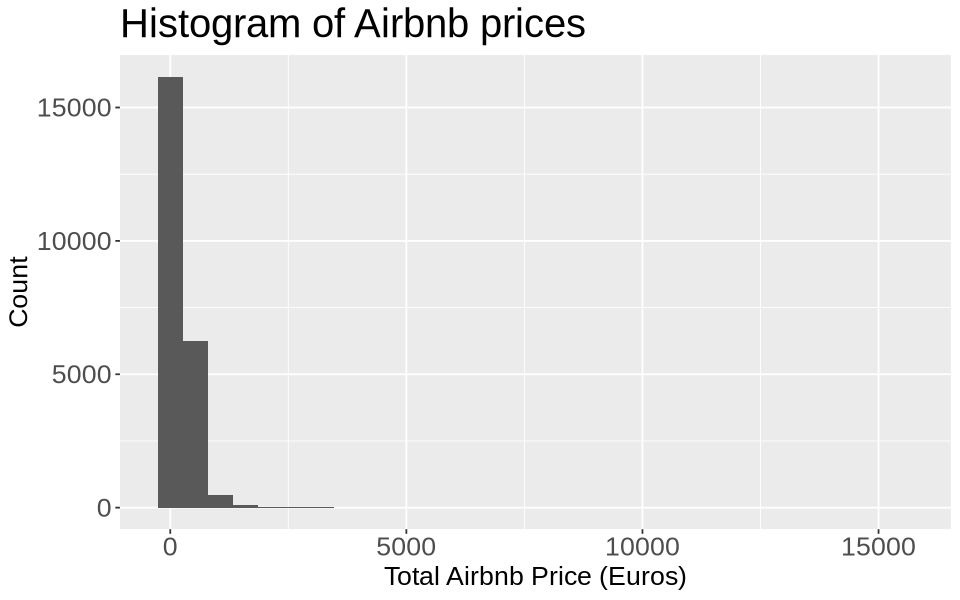

In [7]:
# Main developer: Marcus

# Plot a histogram of our response
options(repr.plot.width = 8, repr.plot.height = 5)

realSum_hist <- data %>%
    ggplot(aes(x=realSum)) +
    geom_histogram() +
    labs(title="Histogram of Airbnb prices", x="Total Airbnb Price (Euros)", y="Count") +
    theme(axis.text = element_text(size = 16), 
          axis.title = element_text(size = 16),
         title=element_text(size = 20))

realSum_hist

Above, we clearly have large outliers in `realSum`. Let's filter the data to remove `realSum` above 1000 euros. In addition, lets plot the mean, and the 95th percentile.

It appears that our response data is very right skewed. 95% of Airbnb price listngs fall below ~`640`, with the average at around `280`. The threshold of `1000` still covers over 95% of listings, and thus is suitable.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


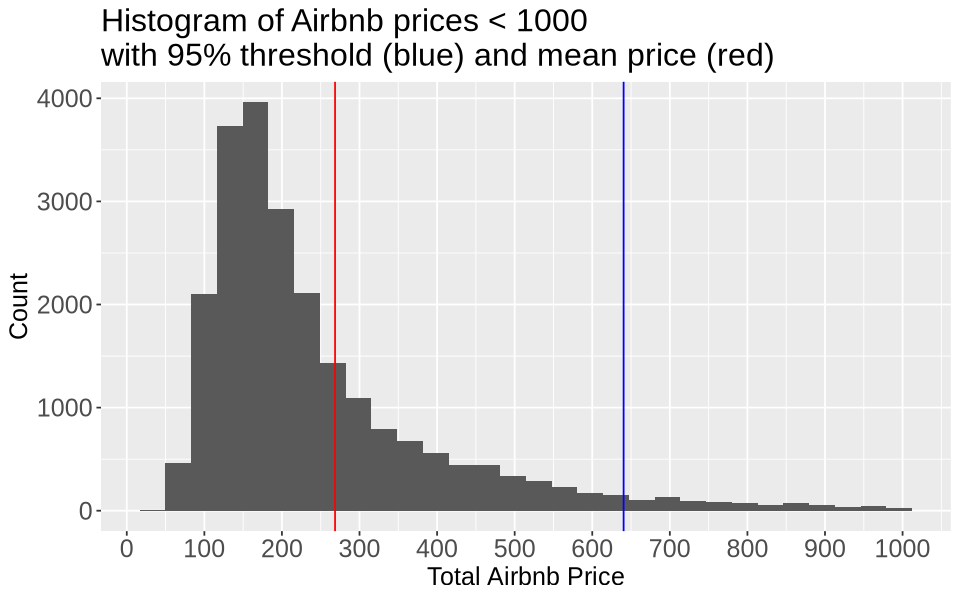

In [8]:
# Main developer: Marcus

data_filt <- data %>% 
    filter(realSum < 1000)

realSum_hist_filt <- data_filt %>%
    ggplot(aes(x=realSum)) +
    geom_histogram() +
    geom_vline(xintercept=mean(data$realSum), color = "red") +
    geom_vline(xintercept=quantile(data$realSum, 0.95), color = "blue") +
    scale_x_continuous(breaks=seq(0, 1000, 100)) +
    ggtitle("Histogram of Airbnb prices < 1000\nwith 95% threshold (blue) and mean price (red)") +
    labs(x="Total Airbnb Price", y="Count") +
    theme(axis.text = element_text(size = 15), 
          axis.title = element_text(size = 15),
         title=element_text(size = 16))
    

realSum_hist_filt

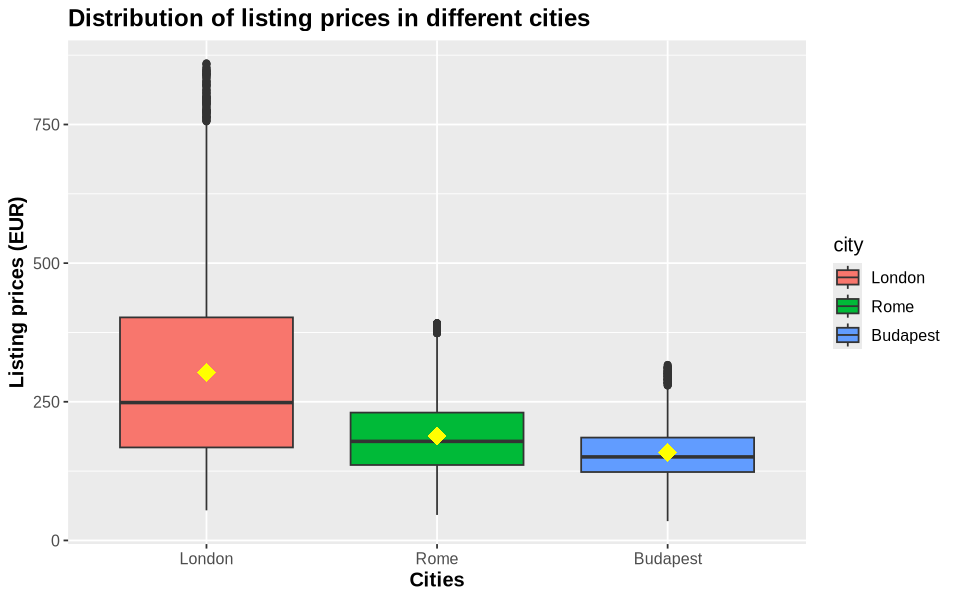

In [9]:
# Main developer: Matthew

# Filters rows with N/A from the data
data <- drop_na(data)

#Altering columns to correct object types and filtering outliers
tidy_data <-
    data %>%
    mutate(   #change columns into correct object types
            across(c(room_type,city),as.factor),
            across(c(multi,biz,isWeekend),as.logical)
    ) %>%
    group_by(city) %>%
    filter(  #filtering outliers from each city by removing listing with prices that lies at the upper 5%
        realSum <= quantile(realSum, 0.95, na.rm = TRUE)) %>%
    ungroup()

#To examine the distribution of listing prices in different cities through a boxplot
city_listing_plot <-
    tidy_data %>%
    ggplot() +
    geom_boxplot(aes(x=city,y=realSum,fill=city))+
    ggtitle("Distribution of listing prices in different cities")+
    xlab("Cities")+
    ylab("Listing prices (EUR)")+
    stat_summary(aes(x=city, y=realSum),
        fun = mean, geom = "point", colour = "yellow", 
        shape = 18, size = 5
    ) +
    theme(
        text = element_text(size = 12),
        plot.title = element_text(face = "bold"),
        axis.title = element_text(face = "bold")
    )
city_listing_plot

The box plot above that shows the distribution of listing prices across Budapest, London and Rome, it helps with the question as it allows one to see how the listing prices varies between cities.

Starting with Budapest, it has the smallest variability in its distribution as well as the lowest median and mean. London, has the largest variability in its distribution and higher median and mean. Lastly, Rome has a variability in its distribution of listing prices thats relatively larger than Budapest as well a larger median and mean than Budapest but lower than London.

Budapest and Rome shares a relatively similar distribution, median and mean of listing prices to one another, but London's wider distribution and higher median and mean may affect the goodness of fit of the model.


Next, [describe more plots here]

> Marcus: I'm not sure if other plots of the raw data are relevant, since we plan to use forward selecton

## END OF BASIC EDA

a) “Exploratory Data Analysis (EDA)”

    Demonstrate that the dataset can be read into R.
    Clean and wrangle your data into a tidy format.
    Plot the relevant raw data, tailoring your plot to address your question.
        Make sure to explore the association of the explanatory variables with the response.
    Any summary tables that are relevant to your analysis.
    Provide code, but be sure not to print output that takes up a lot of screen space.

Your EDA must be comprehensive with high quality plots.

b) “Analysis Plan”

    Describe in written English the methods you used to perform your analysis from beginning to end, and briefly mention R functions used for each part of analysis.
    If relevant to your question, describe the “Variable Selection” process.
    If prediction is the project's aim, describe the test data used or how it was created.
    Describe your model diagnostic and/or evaluation plan, and any reason for choosing your metric(s).



c) “Results”

    Present the code and results of your analysis. 
    You must provide interpretations from each-step of your analysis. For example:
        If inference is the aim of your project, a detailed interpretation of your fitted model(s) is required, as well as a discussion of relevant quantities (e.g., are the coefficients significant?).
        If variable selection was carried out, how and why did you choose your final set of covariates.
        Interpret how well the model fit the data.
    Ensure your tables and/or figures are labelled with a figure/table number.


## Discussion

In this section, you’ll interpret the results you obtained in the previous section with respect to the main question/goal of your project.

    Summarize what you found and the implications/impact of your findings.
    If relevant, discuss whether your results were what you expected to find.
    Discuss how your model could be improved;
    Discuss future questions/research this study could lead to.

## 4) Methods and Plan (MARCUS)

To answer my question, “*Is there an association between Airbnb prices to the distance to the closest metro and if the listing is for weekends?*“, I will use an additive MLR model using `lm()`, with the formula: `realSum ~ metro_dist + isWeekend`. This method is appropriate, because `lm()` allows us to quantify and test the significance of associations, with interpretable coefficients. Through hypothesis testing, we will either have evidence suggesting statistically significant associations (a p-value less than a chosen significance level for that coefficient), or not enough evidence.

However, we need to make the following assumptions:
- Linearity: There is a linear relationship between `realSum` and `metro_dist`.
- Independence: The errors (observations) are independent of each other.
- Normality: Under the CLT, since our data contains 23042 observations, the data and errors in the data are assumed to be normally distributed.
- Homoscedasticity: The errors have constant variance.
- There is no interaction between `metro_dist` and `isWeekend` on Airbnb prices. That is, the estimated change in Airbnb price for every change in distance to the metro does not differ depending on if the listing is on a weekend or not.
- The covariates are not highly correlated (multicollinearity)

There are also the following limitations:
- Incorrect Assumptions: If some of our assumptions turn out to be false, then our results may be invalid or require corrections. For instance, if the relationship is non-linear, we may need to transform some covariates.
- Confounding: Since the model only includes two variables, there may be other variables that influence both price and metro distance (ie. city). This could result in biased estimates, if not included in the model.
- Outliers: Based on the EDA, the data is skewed with outliers, which may result in a model that does not capture representative patterns.


## (4) Methods and Plan (ALIZAH)

We are planning on using multiple linear regression with interaction to estimate Airbnb prices based on city and distance from city centre. An MLR model is the appropriate choice for answering an inference question with 2 inputs and continuous numerical response. We will consider a model with interaction due to the results of the EDA: it seems the slope between `dist` and `realSum` are dependent on city. The formula for this regression will be: `realSum ~ city * dist`.<br>
As with any model, there are certain assumption made about the data. The assumptions about MLR with interactionin relation to our data is as follows: <br>

- **Linearity:** Based on our EDA, we are assuming that our response is approximately a linear function of our inputs and their interaction term  
- **Independence of Errors:** We assume that are observations are independent of each other. This data is from an outside source so we can never know this for sure.  
- **Homoscedasticity:** We can test if the variance of errors is constant through a residuals vs fitted values plot.  
- **Normality of Residuals:** We can see if the residuals have a normal distribution through a Q-Q plot.  
- **Minimal Multicollinearity:** We can check if our inputs are highly correlated through their VIF score.  
- **Correct Specification:** We are assuming that we have correctly specified the model with an interaction term from the result of our EDA. 
- **Correct Variable Encoding:** We ensured that, when we loaded the data, each relevant variable had the correct variable type for the model.  

Following these assumptions ensures that the results from our model are appropriate for inference since we can attain reliable estimates, confidence intervals, and errors.
There are still possible difficulties and weaknesses of our choice in model. Violating some of the assumptions may mean we cannot answer our question since it relies on making inferences. Adding in an interaction term could possible lead to overfitting the model, which may lead to poor predictions. Having too few input variables may mean that we result in a model with high errors if we are missing the potentially large impact of other variables. There's always the possiblity of confounding variables as well. Since this is an external observational study, we cannot easily discover or isolate them from the data. 

To summarize, we can use a MLR model with interaction to infer the association between the listing price of all Airbnbs in Rome, Budapest, and London depending on their city and distance from city centre. Our EDA justifies the appropriateness of this model. However, there are assumptions for this type of model we'd have to further test for and other possible weaknesses that may prevent us from answering our inference question.

<h3><b>4.Methods and Plan (ZAHRA) <b></h3> 

<p>
    To address the question of how <strong>Airbnb price (<code>realSum</code>)</strong> is associated with 
    <strong>distance from the city center (<code>dist</code>)</strong> and 
    <strong>business use (<code>biz</code>)</strong>, 
    I propose using a <strong>multiple linear regression model with an interaction term</strong>:
  </p>




<blockquote><code>realSum ~ biz * dist</code></blockquote>

<p>
    This model includes both the main effects and their interaction, enabling us to determine whether 
    the relationship between price and distance varies by business use status.
  </p>


<h3>Why is this method appropriate?</h3>
  <ul>
    <li>Multiple linear regression models are suitable for analyzing the effect of several predictors on a continuous outcome.</li>
    <li>There is an interaction between  <b>biz</b> and <b>dist</b> as shown by the scatterplot above </li>
    <li>The method is interpretable and statistically efficient when assumptions are met.</li>
  </ul>

<h3>Assumptions of the Method</h3>
  <ul>
    <li><strong>Linearity:</strong> A linear relationship exists between predictors and the outcome.</li>
    <li><strong>Independence:</strong> Observations are independent.</li>
    <li><strong>Homoscedasticity:</strong> Constant variance of residuals across predictor values.</li>
    <li><strong>Normality of residuals:</strong> Residuals should follow a normal distribution.</li>
    <li><strong>No multicollinearity:</strong> Predictors should not be highly correlated.</li>
  </ul>


 <h3>Potential Limitations or Weaknesses</h3>
  <ul>
    <li>Price data may be skewed or contain outliers that violate regression assumptions.</li>
    <li>The relationship may not be strictly linear, limiting model fit.</li>
    <li>Interpreting interaction terms can be complex.</li>
    <li>Unmeasured variables (e.g., amenities, neighborhood) might bias results.</li>
  </ul>

## Methods and plans (MATTHEW)

To answer the question, I believe the best method to approach it would be the Multi-Linear Regression (MLR) model. This is because the MLR model would allow me to observe and predict the change in the price of the listings with every unit increase in distance from city centre or between different room capacities in each city. Two assumptions that will be made for this model is that the change in the price of the listings with the change of room capacities is the same across all cities, and the other assumption is that the change in price of listings with every kilometer increase of distance from the city centre is different between cities. There are limitations of this method, such that if the response and inputs aren't linearly related, it may lead to a model with poor fit. It also assumes that the variation of residuals are homoschedastic, it will affect the standard error of our estimators and invalidate our confidence intervals and p-values if they are heterschedastic. 

## References

At least two citations of literature relevant to the project. The citation format is your choice – just be consistent. Make sure to cite the source of your data as well.

https://www.tandfonline.com/doi/full/10.1080/1331677X.2021.1962380#abstract 
https://www.sciencedirect.com/science/article/pii/S0261517721000388?via%3Dihub 

Testing push - Alizah

Testing push - Matthew

testing push - Zahra